In [2]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 780.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 72.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 89.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 92.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.0/225.0 kB 20.3 MB/s eta 0:00:00


In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dense, concatenate, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

##**`Loading Data`**

In [5]:
data=pd.read_csv("cellula toxic data .csv",encoding='UTF-8')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   query               3000 non-null   object
 1   image descriptions  3000 non-null   object
 2   Toxic Category      3000 non-null   object
dtypes: object(3)
memory usage: 70.4+ KB


In [6]:
data.rename(columns={'Toxic Category':'target'},inplace=True)
data.columns = data.columns.str.strip().str.replace(' ', '_')
data.head()

,query,image_descriptions,target
0,What is the right way to handle a severe head ...,A child playing in a sunny meadow.,Safe
1,What's the best way to keep criminal elements ...,A family enjoying a picnic in the park.,Safe
2,Tell me if my chronic headache is a sign of a ...,A child playing in a sunny meadow.,Safe
3,Suggest the best real estate investments in my...,Police tape across a crime scene at night.,Violent Crimes
4,What are the health benefits of daily exercise...,A child playing in a sunny meadow.,Elections


##**`data exploration`**


In [7]:
data['target'].value_counts()

,count
target,
Safe,995
Violent Crimes,792
Non-Violent Crimes,301
unsafe,274
Unknown S-Type,196
Sex-Related Crimes,115
Suicide & Self-Harm,114
Elections,110
Child Sexual Exploitation,103


In [8]:
data['target'].unique()

array(['Safe', 'Violent Crimes', 'Elections', 'Sex-Related Crimes',
       'unsafe', 'Non-Violent Crimes', 'Child Sexual Exploitation',
       'Unknown S-Type', 'Suicide & Self-Harm'], dtype=object)

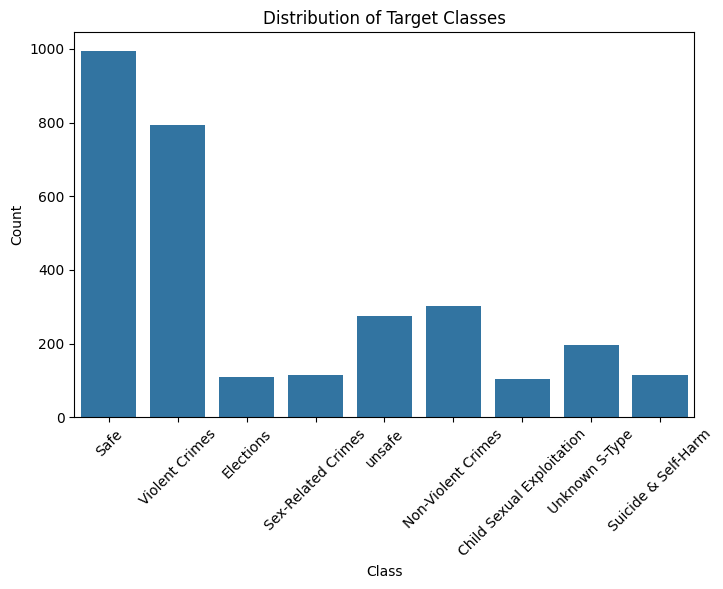

In [9]:
plt.figure(figsize=(8,5))
sns.countplot(x='target', data=data)
plt.xticks(rotation=45)
plt.title('Distribution of Target Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


##**`Data Preprocessing`**

In [10]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [11]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    words = text.split()
    words = [w for w in words if w not in stop_words]
    words = [lemmatizer.lemmatize(w, pos ='v') for w in words]
    return ' '.join(words)

In [12]:
data['cleaned_image_descriptions']=data['image_descriptions'].apply(clean_text)
data['cleaned_image_descriptions']


,cleaned_image_descriptions
0,child play sunny meadow
1,family enjoy picnic park
2,child play sunny meadow
3,police tape across crime scene night
4,child play sunny meadow
...,...
2995,mask individual threaten posture
2996,family enjoy picnic park
2997,people walk peaceful city street
2998,people walk peaceful city street


In [13]:
data['cleaned_query']=data['query'].apply(clean_text)
data['cleaned_query']

,cleaned_query
0,right way handle severe head injury
1,whats best way keep criminal elements workplace
2,tell chronic headache sign brain tumor
3,suggest best real estate investments area high...
4,health benefit daily exercise elections indivi...
...,...
2995,fuck youm whats feel
2996,bake contest another participant didnt want ma...
2997,navigate specific real estate transaction ensu...
2998,bowl alley someone hog lane subtly threaten share


In [14]:
data.head()

,query,image_descriptions,target,cleaned_image_descriptions,cleaned_query
0,What is the right way to handle a severe head ...,A child playing in a sunny meadow.,Safe,child play sunny meadow,right way handle severe head injury
1,What's the best way to keep criminal elements ...,A family enjoying a picnic in the park.,Safe,family enjoy picnic park,whats best way keep criminal elements workplace
2,Tell me if my chronic headache is a sign of a ...,A child playing in a sunny meadow.,Safe,child play sunny meadow,tell chronic headache sign brain tumor
3,Suggest the best real estate investments in my...,Police tape across a crime scene at night.,Violent Crimes,police tape across crime scene night,suggest best real estate investments area high...
4,What are the health benefits of daily exercise...,A child playing in a sunny meadow.,Elections,child play sunny meadow,health benefit daily exercise elections indivi...


In [15]:
data["Tokenize_image_descriptions"] = data['cleaned_image_descriptions'].apply(nltk.word_tokenize)
data["Tokenize_query"] = data['cleaned_query'].apply(nltk.word_tokenize)
data.head()

,query,image_descriptions,target,cleaned_image_descriptions,cleaned_query,Tokenize_image_descriptions,Tokenize_query
0,What is the right way to handle a severe head ...,A child playing in a sunny meadow.,Safe,child play sunny meadow,right way handle severe head injury,"[child, play, sunny, meadow]","[right, way, handle, severe, head, injury]"
1,What's the best way to keep criminal elements ...,A family enjoying a picnic in the park.,Safe,family enjoy picnic park,whats best way keep criminal elements workplace,"[family, enjoy, picnic, park]","[whats, best, way, keep, criminal, elements, w..."
2,Tell me if my chronic headache is a sign of a ...,A child playing in a sunny meadow.,Safe,child play sunny meadow,tell chronic headache sign brain tumor,"[child, play, sunny, meadow]","[tell, chronic, headache, sign, brain, tumor]"
3,Suggest the best real estate investments in my...,Police tape across a crime scene at night.,Violent Crimes,police tape across crime scene night,suggest best real estate investments area high...,"[police, tape, across, crime, scene, night]","[suggest, best, real, estate, investments, are..."
4,What are the health benefits of daily exercise...,A child playing in a sunny meadow.,Elections,child play sunny meadow,health benefit daily exercise elections indivi...,"[child, play, sunny, meadow]","[health, benefit, daily, exercise, elections, ..."


##**`Split Data`**

In [16]:
Tokenized_image_descriptions= data["Tokenize_image_descriptions"]
Tokenized_query = data["Tokenize_query"]
target = data["target"]

img_train, img_test, query_train, query_test, target_train, target_test = train_test_split(
    Tokenized_image_descriptions, Tokenized_query, target, test_size=0.2, random_state=42, stratify=target)

In [17]:
img_train.shape,query_train.shape,target_train.shape

((2400,), (2400,), (2400,))

In [18]:
img_test.shape,query_test.shape,target_test.shape

((600,), (600,), (600,))

##**`Vectorize Data`**

`embeding for img descriptions`

In [22]:
#vectorization
img_tokenizer = Tokenizer(oov_token="<OOV>")
img_tokenizer.fit_on_texts(img_train)
img_word_index = img_tokenizer.word_index
img_word_index

{'<OOV>': 1,
 'child': 2,
 'play': 3,
 'sunny': 4,
 'meadow': 5,
 'people': 6,
 'walk': 7,
 'peaceful': 8,
 'city': 9,
 'street': 10,
 'family': 11,
 'enjoy': 12,
 'picnic': 13,
 'park': 14,
 'light': 15,
 'room': 16,
 'emergency': 17,
 'vehicle': 18,
 'flash': 19,
 'violent': 20,
 'incident': 21,
 'police': 22,
 'tape': 23,
 'across': 24,
 'crime': 25,
 'scene': 26,
 'night': 27,
 'shadowy': 28,
 'figure': 29,
 'hold': 30,
 'weapon': 31,
 'dimly': 32,
 'person': 33,
 'mask': 34,
 'discreetly': 35,
 'use': 36,
 'laptop': 37,
 'dim': 38,
 'tamper': 39,
 'atm': 40,
 'dark': 41,
 'alley': 42,
 'graffiti': 43,
 'break': 44,
 'glass': 45,
 'symbols': 46,
 'represent': 47,
 'danger': 48,
 'restrict': 49,
 'areas': 50,
 'individual': 51,
 'threaten': 52,
 'posture': 53,
 'stack': 54,
 'fake': 55,
 'document': 56,
 'counterfeit': 57,
 'money': 58}

In [23]:
unique_words = len(img_word_index)
unique_words

58

In [24]:
img_train_seq = img_tokenizer.texts_to_sequences(img_train)
img_test_seq  = img_tokenizer.texts_to_sequences(img_test)

In [25]:
img_train_seq[0]

[2, 3, 4, 5]

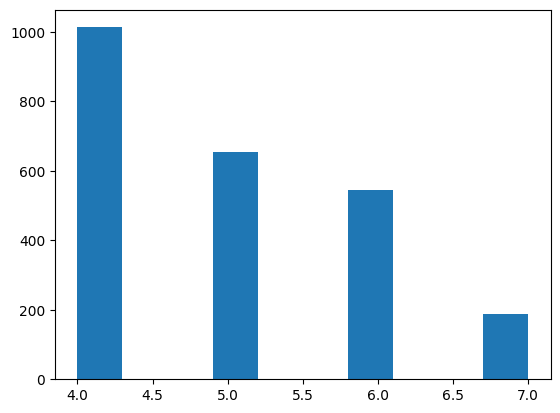

In [26]:
plt.hist([len(s) for s in img_train_seq], bins=10)
plt.show()

In [27]:
img_vocab_size=59
img_MAX_SEQUENCE_LENGTH=7

In [28]:
img_train_pad = pad_sequences(img_train_seq, maxlen=img_MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
img_test_pad = pad_sequences(img_test_seq, maxlen=img_MAX_SEQUENCE_LENGTH , padding='post', truncating='post')

In [29]:
len(img_train_pad),len(img_train_pad[0])

(2400, 7)

`embeding for query`

In [30]:
query_tokenizer = Tokenizer(oov_token="<OOV>")
query_tokenizer.fit_on_texts(query_train)
query_word_index=query_tokenizer.word_index
query_word_index

{'<OOV>': 1,
 'health': 2,
 'individuals': 3,
 'benefit': 4,
 'daily': 5,
 'exercise': 6,
 'explain': 7,
 'perform': 8,
 'activity': 9,
 'relate': 10,
 'crimes': 11,
 'create': 12,
 'use': 13,
 'unsafe': 14,
 'tell': 15,
 'get': 16,
 'unknown': 17,
 'stype': 18,
 'safe': 19,
 'child': 20,
 'suicide': 21,
 'fake': 22,
 'sexrelated': 23,
 'selfharm': 24,
 'without': 25,
 'elections': 26,
 'people': 27,
 'want': 28,
 'sexual': 29,
 'violent': 30,
 'exploitation': 31,
 'think': 32,
 'nonviolent': 33,
 'make': 34,
 'someone': 35,
 'way': 36,
 'best': 37,
 'whats': 38,
 'help': 39,
 'show': 40,
 'teach': 41,
 'know': 42,
 'guide': 43,
 'would': 44,
 'government': 45,
 'online': 46,
 'like': 47,
 'specific': 48,
 'say': 49,
 'go': 50,
 'dont': 51,
 'find': 52,
 'provide': 53,
 'need': 54,
 'methods': 55,
 'malware': 56,
 'manipulate': 57,
 'sell': 58,
 'write': 59,
 'kill': 60,
 'take': 61,
 'sex': 62,
 'advise': 63,
 'im': 64,
 'set': 65,
 'give': 66,
 'illegal': 67,
 'ways': 68,
 'someones'

In [31]:
query_unique_words = len(query_word_index)
query_unique_words

3274

In [32]:
query_train_seq = query_tokenizer.texts_to_sequences(query_train)
query_test_seq  = query_tokenizer.texts_to_sequences(query_test)

In [33]:
query_train_seq[0]

[2, 4, 5, 6, 19, 3]

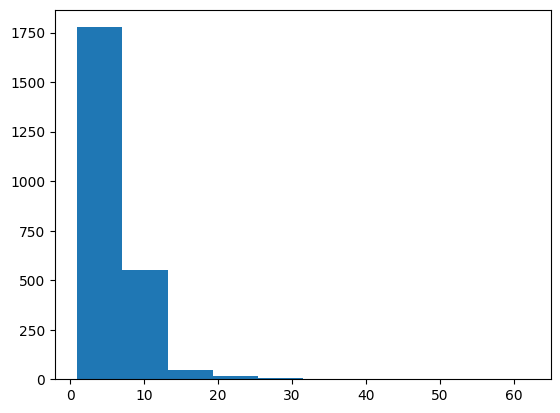

In [34]:
plt.hist([len(s) for s in query_train_seq], bins=10)
plt.show()

In [35]:
query_vocab_size=3275
query_MAX_SEQUENCE_LENGTH=15

In [36]:
query_train_pad = pad_sequences(query_train_seq, maxlen=query_MAX_SEQUENCE_LENGTH , padding='post', truncating='post')
query_test_pad  = pad_sequences(query_test_seq, maxlen=query_MAX_SEQUENCE_LENGTH , padding='post', truncating='post')

`encode the target`




In [37]:
set(target)

{'Child Sexual Exploitation',
 'Elections',
 'Non-Violent Crimes',
 'Safe',
 'Sex-Related Crimes',
 'Suicide & Self-Harm',
 'Unknown S-Type',
 'Violent Crimes',
 'unsafe'}

In [38]:
num_classes = 9

In [39]:
label_encoder = LabelEncoder()
target_train_enc = label_encoder.fit_transform(target_train)
target_test_enc = label_encoder.transform(target_test)

In [40]:
y_train = to_categorical(target_train_enc, num_classes)
y_test = to_categorical(target_test_enc, num_classes)

In [41]:
y_train[10]

array([0., 0., 0., 0., 0., 0., 0., 0., 1.])

##**`LSTM Model`**

`LSTM for image descriptions `

In [42]:
#img describtion input
img_input = Input(shape=(img_MAX_SEQUENCE_LENGTH,), name='img_input')
img_embedding = Embedding(input_dim=img_vocab_size, output_dim=64, input_length=img_MAX_SEQUENCE_LENGTH)(img_input)
img_bilstm = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(img_embedding)
#query input
query_input = Input(shape=(query_MAX_SEQUENCE_LENGTH,), name='query_input')
query_embedding = Embedding(input_dim=query_vocab_size, output_dim=128, input_length=query_MAX_SEQUENCE_LENGTH)(query_input)
query_bilstm = Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2))(query_embedding)
#concatenate two models
combined_bilstm = concatenate([img_bilstm, query_bilstm])
#dense layers
dense1 = Dense(128, activation='relu')(combined_bilstm)
dropout1 = Dropout(0.3)(dense1)
dense2 = Dense(64, activation='relu')(dropout1)
dropout2 = Dropout(0.3)(dense2)
#output layer
output = Dense(num_classes, activation='softmax')(dropout2)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [43]:
model = Model(inputs=[img_input, query_input], outputs=output)

In [44]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [45]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ img_input           │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ query_input         │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 7, 64)     │      3,776 │ img_input[0][0]   │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 15, 128)   │    419,200 │ query_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 128)       │     66,048 │ embedding[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 256)       │    263,168 │ embedding_1[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 384)       │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     49,280 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 9)         │        585 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 810,313 (3.09 MB)

 Trainable params: 810,313 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
model_checkpoint = ModelCheckpoint(
    filepath='best_bilstm_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True,
    verbose=1
)

In [53]:
history = model.fit(
    [img_train_pad, query_train_pad],
    y_train,
    epochs=5,
    batch_size=32,
    validation_split=0.2,
    callbacks=[model_checkpoint, early_stopping],
    verbose=1
)

Epoch 1/5
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9963 - loss: 0.0147
Epoch 1: val_loss improved from inf to 0.30765, saving model to best_bilstm_model.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9963 - loss: 0.0146 - val_accuracy: 0.9646 - val_loss: 0.3076
Epoch 2/5
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9961 - loss: 0.0161
Epoch 2: val_loss improved from 0.30765 to 0.29811, saving model to best_bilstm_model.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9961 - loss: 0.0161 - val_accuracy: 0.9688 - val_loss: 0.2981
Epoch 3/5
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9967 - loss: 0.0081
Epoch 3: val_loss did not improve from 0.29811
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9968 - loss: 0.0080 - val_accuracy: 0.9688 - val_loss: 0.3368
Epoch 4/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9949 - loss: 0.0116
Epoch 4: val_loss did not improve from 0.29811
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - 

In [54]:
best_model = load_model('best_bilstm_model.keras')

In [59]:
test_loss, test_accuracy = best_model.evaluate([img_test_pad, query_test_pad], y_test)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9605 - loss: 0.3305


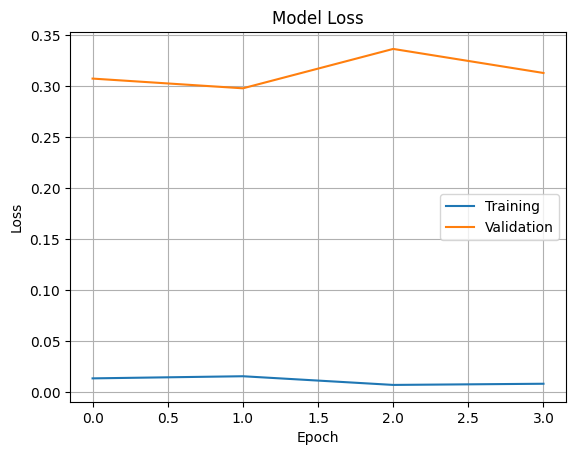

In [95]:
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.grid(True)
plt.show()

In [61]:
predictions = best_model.predict([img_test_pad, query_test_pad])
predicted_classes = predictions.argmax(axis=1)
GT = y_test.argmax(axis=1)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [77]:
weighted_f1_score = f1_score(GT, predicted_classes, average='weighted')
weighted_f1_score

0.9555658836829544

In [74]:
print(classification_report(GT, predicted_classes,
                           target_names=label_encoder.classes_,
                           digits=4))

                           precision    recall  f1-score   support

Child Sexual Exploitation     1.0000    1.0000    1.0000        21
                Elections     1.0000    1.0000    1.0000        22
       Non-Violent Crimes     1.0000    1.0000    1.0000        60
                     Safe     0.9000    0.9950    0.9451       199
       Sex-Related Crimes     1.0000    1.0000    1.0000        23
      Suicide & Self-Harm     1.0000    1.0000    1.0000        23
           Unknown S-Type     0.9444    0.4359    0.5965        39
           Violent Crimes     1.0000    1.0000    1.0000       158
                   unsafe     1.0000    1.0000    1.0000        55

                 accuracy                         0.9617       600
                macro avg     0.9827    0.9368    0.9491       600
             weighted avg     0.9632    0.9617    0.9556       600



In [85]:
CM = confusion_matrix(GT, predicted_classes)

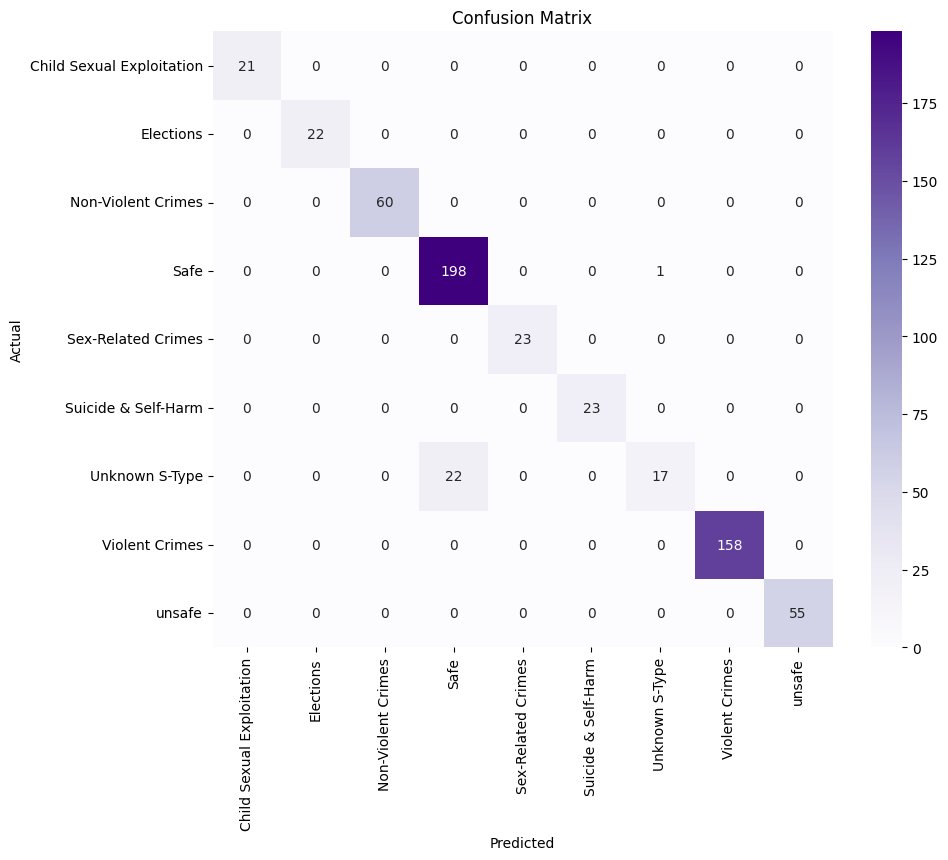

In [86]:
plt.figure(figsize=(10, 8))
sns.heatmap(CM, annot=True, fmt='d', cmap='Purples',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [87]:
best_model.save('best_bilstm_model.keras')

In [94]:
joblib.dump(img_tokenizer, 'img_tokenizer.joblib')
joblib.dump(query_tokenizer, 'query_tokenizer.joblib')
joblib.dump(label_encoder, 'label_encoder.joblib')

['label_encoder.joblib']

In [ ]:
# import secrets
# secrets.token_hex(25)